Καμάρης Άγγελος
sdi1900070

**Τεχνητή Νοημοσύνη ΙΙ**

(ακαδ. έτος 2022-23)

In [67]:
#headers used throughout the programm
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [68]:

file=open('/content/drive/MyDrive/imdb-reviews.csv','r', encoding="utf-8")

df= pd.read_csv(file, sep='\t' , on_bad_lines='skip')       #open the file stored in the drive and seperate it by tabs
test_df = None

#test_df=pd.read_csv("file name", sep='\t' , on_bad_lines='skip')   #you can use this to create a test dataframe, but you must enter the filename of the variable that holds the file.

print(df)

df.describe()



                                                    url  rating  \
0      http://www.imdb.com/title/tt0120623/usercomments    10.0   
1      http://www.imdb.com/title/tt0043117/usercomments     9.0   
2      http://www.imdb.com/title/tt0043117/usercomments    10.0   
3      http://www.imdb.com/title/tt0835204/usercomments     4.0   
4      http://www.imdb.com/title/tt0499603/usercomments    10.0   
...                                                 ...     ...   
45003  http://www.imdb.com/title/tt0449000/usercomments     1.0   
45004  http://www.imdb.com/title/tt0109382/usercomments     1.0   
45005  http://www.imdb.com/title/tt0375560/usercomments     1.0   
45006  http://www.imdb.com/title/tt0165107/usercomments     1.0   
45007  http://www.imdb.com/title/tt0041513/usercomments    10.0   

                                                  review  
0      I thought this was a quiet good movie. It was ...  
1      Wagon Master is a very unique film amongst Joh...  
2      This film h

,rating
count,45008.000000
mean,5.481914
std,3.494293
min,1.000000
25%,2.000000
50%,7.000000
75%,9.000000
max,10.000000


In [69]:
def preprocess(df):       #This function 

  stopwords = nltk.corpus.stopwords.words("english")      #make a list of stopwords, from the english language

  df['review'] = df['review'].astype(str).str.lower()     #make everything lowercase
  regexp = RegexpTokenizer('\w+')
  df['review']=df['review'].apply(regexp.tokenize)        #tokenize the reviews from strings to lists of words


  df['review'] = df['review'].apply(lambda x: [item for item in x if item not in stopwords])    #remove all stopwords from those lists


  bigwords = df['review'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))      #keep only words that contain more that 2 letters

  all_words = ' '.join([word for word in bigwords])      #merge them and tokenize them again to create a frequency dictionary
  tw = nltk.tokenize.word_tokenize(all_words)

  fdist = FreqDist(tw)


  df['review'] = df['review'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))  #remove not frequent words


  lem = WordNetLemmatizer()

  df['review'] = df['review'].apply(lem.lemmatize)                  #lematize


  stem = SnowballStemmer("english")

  df['review'] = df['review'].str.split().apply(lambda x: [stem.stem(y) for y in x])      #stematize


  df['review'] = df['review'].apply(lambda x: ' '.join([item for item in x]))         #merge the lists of words to strings again so they can be passed onto the vectorizer

preprocess(df)

if test_df != None:                     #if a testset is given, preprocess it
  preprocess(test_df)

In [70]:
X=df.drop('rating', axis=1)
X=df.drop('url', axis=1)
Y = df[['rating']] # [[ ]] used to keep the label
Y.loc[Y['rating'] <= 4, 'rating'] = 0                 #keep only valuable data, for X and Y
Y.loc[Y['rating'] >= 7, 'rating'] = 1


if test_df == None:
  X_train_unvect, X_test_unvect, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)              #if we are not given a test set, we will split our current data.
else:
  X_train_unvect = X
  Y_train = Y
  X_test_unvect = test_df.drop('rating', axis=1)
  X_test_unvect = test_df.drop('url', axis=1)
  Y_test = test_df[['rating']] # [[ ]] used to keep the label

  Y_test.loc[Y_test['rating'] <= 4, 'rating'] = 0
  Y_test.loc[Y_test['rating'] >= 7, 'rating'] = 1

vectorizer = TfidfVectorizer(max_features=1000)                   #using a vectorizer to turn strings to arrays.



data1=vectorizer.fit_transform(X_train_unvect['review'])               #I only use the reviews for my training
X_train = data1.toarray()
data2=vectorizer.transform(X_test_unvect['review'] )
X_test = data2.toarray()



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [71]:
classifier = LogisticRegression(max_iter=2000)
classifier.fit(X_train, np.ravel(Y_train))            #run the classifier

LogisticRegression(max_iter=2000)

accurasy from cross validation: 0.8646242603550297
F1 Score Train: 1.0
F1 Score Validation: 0.00444642063139173
F1 Score Train: 0.9110901665095822
F1 Score Validation: 0.8505949757602468
F1 Score Train: 0.8969168483338523
F1 Score Validation: 0.8569133007084946
F1 Score Train: 0.8978483392521412
F1 Score Validation: 0.8628140335457409
F1 Score Train: 0.8843591370558375
F1 Score Validation: 0.8636363636363635
F1 Score Train: 0.89041781336002
F1 Score Validation: 0.8683768179492801
F1 Score Train: 0.8877055599060298
F1 Score Validation: 0.8682590855803048
F1 Score Train: 0.8843779149824545
F1 Score Validation: 0.86897458369851
F1 Score Train: 0.882648258550361
F1 Score Validation: 0.8691896640070272
F1 Score Train: 0.8825555903538992
F1 Score Validation: 0.8702659145850121


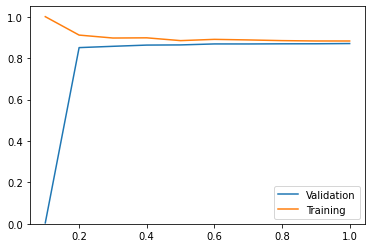

In [72]:
import matplotlib.pyplot as plt


crossresult=cross_val_score(classifier, X_test, np.ravel(Y_test), cv=20, scoring="accuracy")

print("accurasy from cross validation: " + str(crossresult.mean()))

list_f1=[]
list_f1_train=[]
list_sample_size=[]

for times in range(10):
  # training
  #
  X, X_unused, y, y_unused = train_test_split(X_train, Y_train, test_size=1 - (times * 0.1 + 0.001))

  classifier = LogisticRegression(max_iter=2000)
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  # validation
  # 
  results = classifier.predict(X_test)

  # score
  #
  f1_train = f1_score(y, results_train)
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(Y_test, results)
  print("F1 Score Validation: " + str(f1))

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

# print(plot_data)
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

In [73]:
predictions_train = classifier.predict(X_train)
predictions_val = classifier.predict(X_test)

print(predictions_val)
print(np.ravel(Y_test))

print(predictions_val.sum())
print(np.ravel(Y_test).sum())

# F-Score

f1_train = f1_score(Y_train, predictions_train)
f1_val = f1_score(Y_test, predictions_val)

print("F1 Score (train):", f1_train)
print("F1 Score (validation):", f1_val)

# Recall

r_train = recall_score(Y_train, predictions_train)
r_val = recall_score(Y_test, predictions_val)

print("Recall Score (train):", r_train)
print("Recall Score (validation):", r_val)

# Prediction score

p_train = precision_score(Y_train, predictions_train)
p_val = precision_score(Y_test, predictions_val)

print("Precision Score (train):", p_train)
print("Precision Score (validation):", p_val)


[1. 1. 1. ... 0. 1. 1.]
[1. 0. 1. ... 0. 1. 1.]
6919.0
6732.0
F1 Score (train): 0.88153321015877
F1 Score (validation): 0.8702659145850121
Recall Score (train): 0.8921779918864098
Recall Score (validation): 0.8823529411764706
Precision Score (train): 0.8711394442037507
Precision Score (validation): 0.8585055643879174
